In [5]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
import time
from sklearn.ensemble import IsolationForest
from pyod.models.iforest import IForest
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import fetch_openml

def load_dataset(dataset_name):
    if dataset_name == "mnist":
        X, y = fetch_openml('mnist_784', version=1, return_X_y=True, as_frame=False)
        y = (y == '0').astype(int)
    elif dataset_name == "arrhythmia":
        data = pd.read_csv('http://archive.ics.uci.edu/ml/machine-learning-databases/arrhythmia/arrhythmia.data', header=None)
        data = data.replace('?', np.nan)
        data = data.astype(float) 
        data = data.fillna(data.mean())
        
        X = data.iloc[:, :-1].values
        y = (data.iloc[:, -1] != 1).astype(int)
    else:
        raise ValueError(f"Dataset {dataset_name} not implemented")
    
    return X, y

In [6]:
def evaluate_model(clf, X_train, X_test, y_test):
    start_time = time.time()
    clf.fit(X_train)
    training_time = time.time() - start_time
    
    start_time = time.time()
    # Handle different scoring methods for pyod and sklearn implementations
    if hasattr(clf, 'score_samples'):
        # sklearn IsolationForest
        y_scores = -clf.score_samples(X_test)
    else:
        # pyod IForest
        y_scores = clf.decision_function(X_test)
    inference_time = time.time() - start_time
    
    auc = roc_auc_score(y_test, y_scores)
    
    return {
        'auc': auc,
        'training_time': training_time,
        'inference_time': inference_time
    }

datasets = ['mnist', 'arrhythmia']
models = {
    'IForest': lambda: IForest(random_state=42),
    'SK-IForest': lambda: IsolationForest(random_state=42)
}

results = []

for dataset_name in datasets:
    X, y = load_dataset(dataset_name)
    X = StandardScaler().fit_transform(X)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    for model_name, model_constructor in models.items():
        clf = model_constructor()
        metrics = evaluate_model(clf, X_train, X_test, y_test)
        results.append({
            'Dataset': dataset_name,
            'Model': model_name,
            **metrics
        })

results_df = pd.DataFrame(results)

c:\Python310\lib\site-packages\sklearn\datasets\_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(



Performance Metrics Table:
   Dataset      Model   auc  training_time  inference_time
     mnist    IForest 0.804         32.824           5.707
     mnist SK-IForest 0.804          0.322           5.744
arrhythmia    IForest 0.771          0.276           0.037
arrhythmia SK-IForest 0.771          0.147           0.046


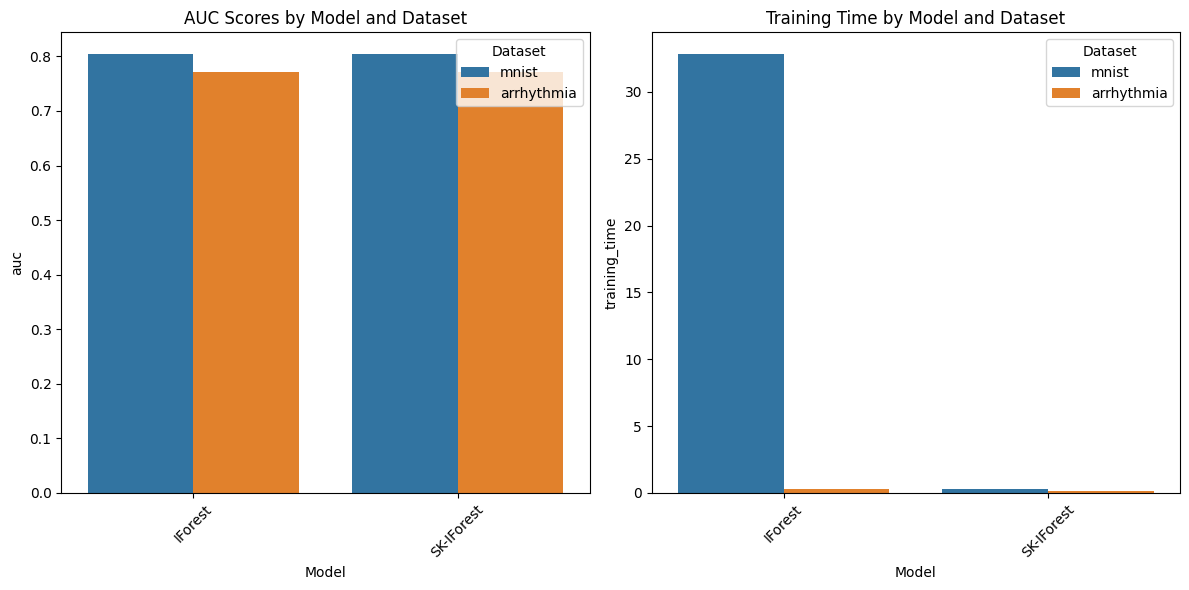

In [7]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.barplot(data=results_df, x='Model', y='auc', hue='Dataset')
plt.title('AUC Scores by Model and Dataset')
plt.xticks(rotation=45)

plt.subplot(1, 2, 2)
sns.barplot(data=results_df, x='Model', y='training_time', hue='Dataset')
plt.title('Training Time by Model and Dataset')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('performance_comparison.png')

print("\nPerformance Metrics Table:")
print(results_df.round(3).to_string(index=False))